In [15]:
# %load_ext line_profiler
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import imageio
import numpy as np
import matplotlib.pyplot as plt
import cv2
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from collections import deque

from torchvision import transforms as T

import gym
from gym.spaces import Box
from gym.wrappers import FrameStack

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
env = gym_super_mario_bros.make("SuperMarioBros-v0", render_mode='rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

env.reset()
next_state, reward, done, trunc, info = env.step(action=0)

In [18]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, trunk, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, trunk, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = T.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transforms = T.Compose(
            [T.Resize(self.shape), T.Normalize(0, 255)]
        )
        observation = transforms(observation).squeeze(0)
        return observation

class CustomRewardWrapper(gym.Wrapper):
    def __init__(self, env):
        super(CustomRewardWrapper, self).__init__(env)
        # self.coin_reward = 10
        self.previous_coins = 0
        self.previous_score = 0

    def step(self, action):
        state, reward, done, trunc, info = self.env.step(action)

        # if info['coins'] > self.previous_coins:
        #     reward += self.coin_reward

        # Check for score changes
        reward += (info['score'] - self.previous_score)

        # Update previous values
        # self.previous_coins = info['coins']
        self.previous_score = info['score']

        return state, reward, done, trunc, info

    def reset(self, **kwargs):
        # self.previous_coins = 0
        self.previous_score = 0
        return self.env.reset(**kwargs)


# Apply Wrappers to environment
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)
env = FrameStack(env, num_stack=4)
env = CustomRewardWrapper(env)

In [19]:
s_size = env.observation_space.shape
a_size = env.action_space.n
print(env.observation_space.shape, s_size, a_size)

(4, 84, 84) (4, 84, 84) 7


In [20]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        # Define the three layers here
        # Code Here
        self.cnn = self.__build_cnn(4, a_size, h_size)

    def forward(self, x):
        return self.cnn(x)

    def act(self, state):
        state = np.array(state)
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

    def __build_cnn(self, c, output_dim, hidden_dim):
        return nn.Sequential(
            nn.Conv2d(in_channels=c, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 256),
            # nn.Flatten(),
            # nn.Linear(1296, hidden_dim),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=1)
        )

In [21]:
def reinforce(policy, optimizer, n_training_episodes, max_t, gamma, print_every):
    scores = []
    # Line 3 of pseudocode
    for episode in range(n_training_episodes):
        log_probs = []
        rewards = []
        state, _ = env.reset() # Code Here: reset the environment
        # Line 4 of pseudocode
        while True:
            action, log_prob = policy.act(state) # Code Here: get the action
            state, reward, done, truncated, info = env.step(action) # Code Here: take an env step
            
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                break
        scores.append(sum(rewards))

        # Compute returns
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)
        returns = torch.tensor(returns)

        ## standardization for training stability
        eps = np.finfo(np.float32).eps.item()

        ## eps is added to the standard deviation of the returns to avoid numerical instabilities
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        # Policy gradient update
        policy_loss = []
        for log_prob, R in zip(log_probs, returns):
            policy_loss.append(-log_prob * R)
        policy_loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        print(f"Episode {episode+1}/{n_training_episodes}, Total Reward: {sum(rewards)}")

    return scores

In [22]:
mario_params = {
    "h_size": 512,
    "n_training_episodes": 10,
    "n_evaluation_episodes": 100,
    "max_t": 100000,
    "gamma": 0.99,
    "lr": 0.001,#1e-4, #0.00025
    "state_space": s_size,
    "action_space": a_size,
}

In [23]:
mario_policy = Policy(mario_params["state_space"], mario_params["action_space"], mario_params["h_size"]).to(device)
mario_optimizer = optim.Adam(mario_policy.parameters(), lr=mario_params["lr"])

In [24]:
# %lprun -f reinforce reinforce(mario_policy, mario_optimizer, mario_params["n_training_episodes"], mario_params["max_t"], mario_params["gamma"], 1)
scores = reinforce(mario_policy,
                   mario_optimizer,
                   mario_params["n_training_episodes"],
                   mario_params["max_t"],
                   mario_params["gamma"],
                   10)

/var/folders/l3/zflq6mt5639g0h00w52sq__00000gn/T/ipykernel_1189/4172923039.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns)


Episode 1/10, Total Reward: 1795.0
Episode 2/10, Total Reward: 2485.0
Episode 3/10, Total Reward: 1974.0
Episode 4/10, Total Reward: 1781.0
Episode 5/10, Total Reward: 2873.0
Episode 6/10, Total Reward: 3828.0
Episode 7/10, Total Reward: 2035.0
Episode 8/10, Total Reward: 3144.0
Episode 9/10, Total Reward: 2945.0
Episode 10/10, Total Reward: 2574.0


In [25]:
def record_video(env, policy, out_directory, fps=30, max_frames = 100000):
  images = []
  done = False
  state, _ = env.reset()
  frame_counter = 0
  while not done and frame_counter < max_frames:
    action, _ = policy.act(state)
    state, reward, done, tunc, info = env.step(action)
    img = env.render()
    x = img.copy()
    images.append(x)
    frame_counter += 1
  imageio.mimsave(out_directory, [np.array(img) for img in images], fps=fps)

In [26]:
record_video(env, mario_policy, './replay.mp4', 30)

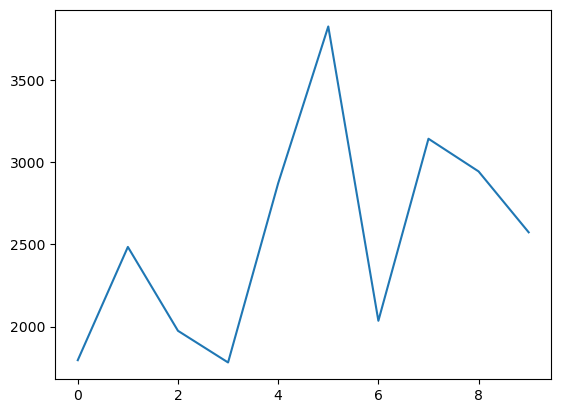

In [27]:
plt.plot(scores)